# Reinforcement learning basics
**Reinforcement learning (RL)** is a branch of machine learning where an **agent** learns to make decisions by interacting with an **environment**. It's inspired by how humans and animals learn from trial and error, by taking actions and receiving feedback. In this notebook, we'll introduce the key concepts of reinforcement learning, and apply them to a simple problem.

## Agent-Environment interaction
We try to frame most RL problems in this format. At each timestep **t** the **agent** receives observation $ O $ which is some representation of environment's **state** $ S_t \in \mathit{S}$ and on that basis it selects an **action** $ A_t \in \mathit{A(s)} $. One time step later, in part as a consequence of its action, the agent receives a numerical reward, $ R_{t+1} \in \mathit{R} \sub \mathbb{R} $ , and finds itself in a new state $ S_{t+1} $, together thereby give rise to a sequence or **trajectory** (or *history*) that begins like this: $ S_0, A_0, R_1, S_1, A_1, R_2, S_2, A_2, R_3, \ldots $

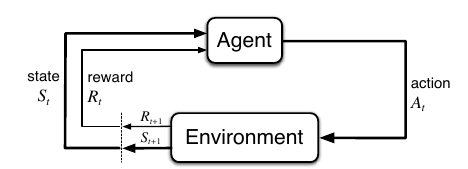

In a finite problem the sets $\mathit{S}$, $\mathit{A}$ and $\mathit{R}$ have finite number of elements.

### Example of finite environment
One of the simplest environments available in **Gymnasium** framework is **[Frozen Lake (click to read documentation)](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)**.


In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 5)

def render(env: gym.Env):
    """Helper function to render the game frame."""
    frame = env.render()
    assert frame is not None
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

from matplotlib.table import Table

def visualize_table(table_data, title=None):
    _, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax=ax, bbox=[0, 0, 1, 1])

    nrows, ncols = 4, 4
    width, height = 1.0 / ncols, 1.0 / nrows

    for i in range(len(table_data)):
        x = i % 4
        y = i // 4
        tb.add_cell(y, x, width, height, text=table_data[i], loc="center", facecolor="white")

    ax.add_table(tb)
    if title:
        ax.set_title(title)

Let's initialize the Frozen Lake environment. We will load 4x4 grid and visualize it. The goal of this game is to reach the present and not fall into the frozen lake.

In [ ]:
env = gym.make(
    'FrozenLake-v1',
    map_name="4x4", 
    is_slippery=False,
    render_mode='rgb_array'
)

print("S: ", env.observation_space)
print("A: ", env.action_space)
print("R: ", env.reward_range)

O, info = env.reset()

print("Observation: ", O)
render(env)
visualize_table(range(16), "State Space")

As you can see this is a **finite** environment
- State set ($S$) has 16 members (and 5 of them are **terminal** states)
- Action set ($A$) has 4 members (left, down, right, up)
- Reward set has ($R$) 2 members (1 for reaching the present and 0 for every other move)

In this case the environment is a **fully observable** one (observation is equivalent to the state), *however keep in mind that agent doesn't see the board as we do (from the bird view) but only observes on which tile it currently is, if he received reward and if it is a terminal state. The rendering of the board is just for visualization purposes.*

Let's see what happens when we take actions in the environment.

In [ ]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

S1, R1, T1, _, I1 = env.step(RIGHT)
print("Observation/State S1: ", S1)
print("Reward R1: ", R1)
print("Is terminal T1: ", T1)

render(env)

As you can see that after taking action $ A_0 = right $ we received the reward $ R_1 = 0 $ and the observation $S_1 = 1$. We also received the information that we are not in a terminal state yet and that this transition had probability of 1 (we are in a **deterministic** environment).

In [ ]:
S2, R2, T2, _, I2 = env.step(RIGHT)
print("Observation/State S2: ", S2)
print("Reward R2: ", R2)
print("Is terminal T2: ", T2)
render(env)

This time after taking action $ A_1 = down $ we received the reward $ R_2 = 0 $ and the observation $S_2 = 5$ but this time we found ourselves in a terminal state as we have fallen into the lake. 

This is the end of the **episode** with **trajectory** of $ S_0, A_0, R_1, S_1, A_1, R_2, S_2 = 0, right,0,1,down,0,5 $. \
The episode length is usually denoted as **T** and in this case $ T = 2 $ and $S_T = S_2$ is a terminal state. 

Consider another **trajectory**

In [ ]:
env.reset()

actions = [DOWN, DOWN, RIGHT, RIGHT, DOWN, RIGHT]

for i, A in enumerate(actions):
    O, R, T, _, _ = env.step(A)
    print(f"A{i}: ", A)
    print(f"S{i+1}: ", O)
    print(f"R{i+1}: ", R)
    print("Is terminal: ", T)
    render(env)

Now we can observe that the agent reaches the goal in 6 steps ($T=6$ the terminal state is $S_6$), all the immediate rewards were equal to 0 except the last one $R_6 = 1$

## Markov Decision Process (MDP)

Mathematical formalization of such decision making process is called **Markov Decision Process (MDP)**. The environment is said to have the **Markov property** if the future state depends only on the current state and action, and not on the past **trajectory**. This is a very strong assumption and in practice it's often violated. It helps to simplify the problem as if we learn optimal policies for some states we can hope that it will not change in the future.

MDPs can be entirelly defined by the following function: \
$p(s', r | s, a) = Pr(S_{t+1} = s', R_{t+1} = r | S_t = s, A_t = a)$ \
In other words - *the probability of transitioning to state $s'$ and receiving reward $r$ given that we are in state $s$ and took action $a$ should be defined for all state-action pairs.*

The Frozen Lake environment was an example of a **deterministic** MDP, all probabilities were equal to 1 or 0. for example $p(1,0|0,right) = 1$ and $p(1,1|0,right) = 0$. However it is possible to enable **stochastic** transitions by setting the `is_slippery` parameter to `True` in the environment initialization. (Now there is only 1/3 chance that the agent will move in the direction it wanted and 2/3 that it will move into one of orthogonal directions)

In [ ]:
env = gym.make(
    'FrozenLake-v1',
    map_name="4x4", 
    is_slippery=True,
    render_mode='rgb_array'
)

O, info = env.reset(seed=1)

render(env)

In [ ]:
def debug_step(env: gym.Env, A: int, t: int):
    O, R, T, _, I = env.step(A)
    print(f"A{t}: {A}, S{t+1}: {O}, R{t+1}: {R}, Terminal: {T}")
    print("Info: ", I)
    render(env)

debug_step(env, DOWN, t=0)

As you can see we performed action $down$ but ended up in the state 1 as if we moved $right$ instead. 
$1/3$ lead to the desired state and $2/3$ lead to the orthogonal states, but we never slip into the opposite direction, this opens doors for interesting strategies, for example if we want to be sure to avoid the lake we can choose action $up$ to be sure we won't slip into it.

In [ ]:
debug_step(env, UP, t=1)

staying in $S=1$, going back to $S=0$ or going to state $S=2$ all had the same probability (1/3) after choosing action $up$ this time we got lucky and moved closer to the goal. Have we chosen action $right$ we would have 1/3 chance of slipping down to $S=5$ and loosing

## Goals and Reward hypothesis
When training RL agent we want it to acomplish some **goal**. The goal is usually some high level objective that is not directly encoded in the environment. For example in the Frozen Lake the goal/purpose is *to reach the goal without falling into the lake*.

The **reward hypothesis** states that: \
*All of what we mean by goals and purposes can be well thought of as the maximization of the expected value of the cumulative sum of a received rewards*

### Return
The cumulative sum of rewards to be received after time step t is called **return** (denoted as: $G_t = R_{t+1} + R_{t+2} + \ldots + R_T$). To achieve the high level goal we need to maximize the expected return. This way agent might perform actions that in the short term are not beneficial but in the long term lead to the highest return.

*Notice that if you define the return of terminal state to 0 ($G_T = 0$) you can formulate the return recursively as: $G_t = R_{t+1} + G_{t+1}$*

#### Discounted return
In practice we often use **discounted return** where we multiply each reward by a factor $\gamma^t$ where $\gamma \in [0,1]$ is called the discount factor. 
$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \ldots + \gamma^{T-t-1} R_T$
This makes sense as we are less likely to predict rewards long in the future than the immediate ones. \
If $\gamma = 0$ the agent will only care about the immediate reward ($G_t = R_{t+1}$) \
If $\gamma = 1$ the agent will care about all future rewards equally (*the same as undiscounted case mentioned previously*).

The discounted return can be formulated recursively as: $G_t = R_{t+1} + \gamma G_{t+1}$

### Exercise from the book
Suppose = 0.5 and the following sequence of rewards is received $R_1 = 1$,
$R_2 = 2$, $R_3 = 6$, $R_4 = 3$, and $R_5 = 2$, with $T = 5$. What are $G_0, G_1 , . . ., G_5$?

*Hint: Work backwards*

## Calculating returns

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython import display
from typing import List, Tuple

Trajectory = List[Tuple[int, float, int]]


def run_episode(env: gym.Env, actions: list) -> Trajectory:
    """Run episode by applying list of actions and return list of (state, reward) pairs."""
    S, I = env.reset()
    R = 0.0

    frames = []
    frames.append(env.render())

    trajectory = []
    for i, A in enumerate(actions):
        trajectory.append((R, S, A))
        S, R, T, _, I = env.step(A)
        frames.append(env.render())
    trajectory.append((R, S, None))

    # Animation
    fig = plt.figure() 

    def animate(i):
        plt.imshow(frames[i])
        plt.axis('off')

    ani = FuncAnimation(fig, animate, frames=len(frames))
    video = ani.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

    return trajectory

def discounted_return(t: Trajectory, gamma: float):
    """Calculate the return of a trajectory."""
    return sum([R * (gamma ** i) for i, (R, _, _) in enumerate(t)])

In [ ]:
env = gym.make(
    'FrozenLake-v1',
    map_name="4x4", 
    is_slippery=False,
    render_mode='rgb_array'
)

trajectory = run_episode(env, [RIGHT, RIGHT, DOWN, DOWN, LEFT, DOWN, RIGHT, RIGHT])
print(trajectory)

Let's calculate how return would look like on each state of this episode. We will use multiple discount factors ($\gamma$) to see how it affects the return. 
Notice that:
- terminal state has always return of 0 as no more rewards can be received after it.
- we can only evaluate the return of the states that were visited in the episode.

In [ ]:
def evaluate_trajectory(T: Trajectory, gammas=[0, 0.5, 0.9, 1]):
    for gamma in gammas:
        G_table = [None for _ in range(16)]
        G = 0 # Terminal
        for R, S, _ in reversed(T):
            G_table[S] = G
            G = R + gamma * G

        G_table = [f"{G:.2f}" if G is not None else "" for G in G_table]
        visualize_table(G_table, f"Discounted Return (gamma={gamma})")

evaluate_trajectory(trajectory)

Let's consider a more optimal episode, where the agent reaches the goal in a shorter amount of steps, notice that on average returns will be higher than in the longer episode, which is another useful feature of **discounting**

In [ ]:
trajectory = run_episode(env, [DOWN, DOWN, RIGHT, RIGHT, DOWN, RIGHT])
evaluate_trajectory(trajectory, gammas=[0.5, 0.9])

Let's consider episode that ends in agent falling into the lake, notice that we never get any reward in such episode so all returns are equal to 0!

In [ ]:
trajectory = run_episode(env, [DOWN, DOWN, RIGHT, UP])
evaluate_trajectory(trajectory)

## TODO:

- Policy
- Value
- Bellman equation
- Generalized policy iteration
- Monte carlo vs Temporal difference

Bibliography:
- Reinforcement Learning An Introduction (2nd edition) - Richard Sutton and Andrew Barto
- Gymnasium framework (https://gymnasium.farama.org/)